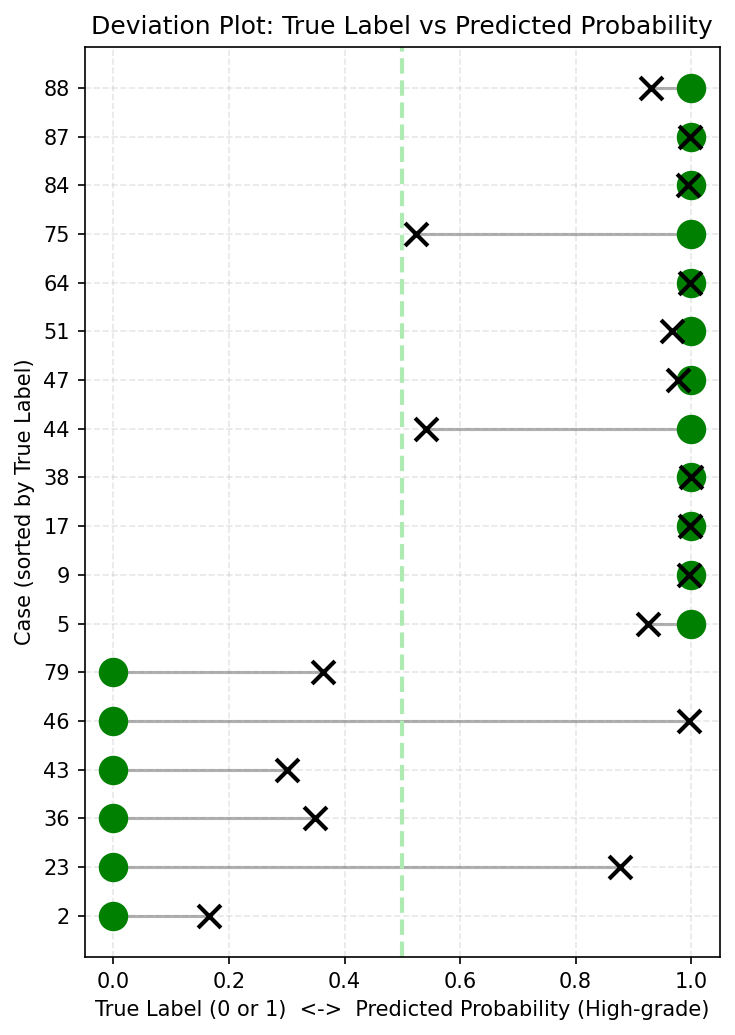

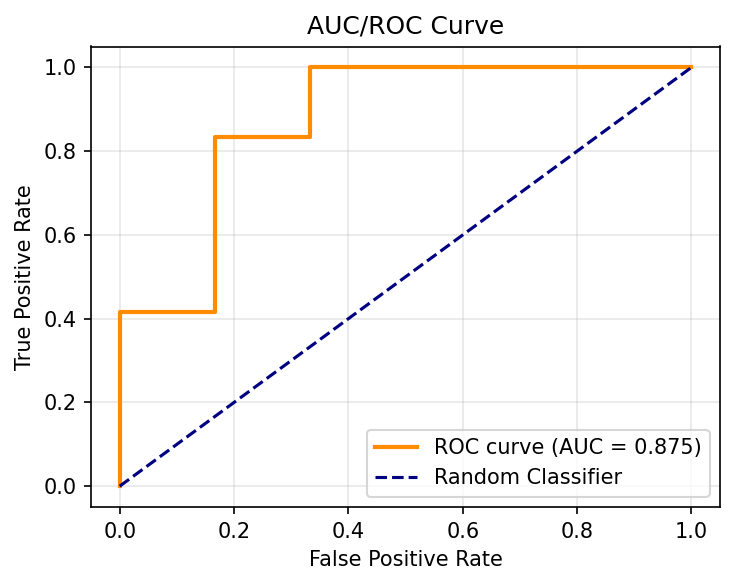


Computed AUC = 0.875


In [2]:
# =====================================================
# Combined Visualization Script
# - Green-dot deviation plot
# - AUC/ROC curve
# =====================================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -----------------------------------------------------
# Load predictions
# -----------------------------------------------------
df = pd.read_csv("/projects/e32998/MIL_training/pres_4_runs/run_20251116_111031/predictions.csv")

# Sort so true=0 cases appear first (optional but cleaner)
df_sorted = df.sort_values(["true_label", "case_id"]).reset_index(drop=True)
df_sorted["case_str"] = df_sorted["case_id"].astype(str)

# -----------------------------------------------------
# 1. Deviation Plot (True vs Probabilities)
# -----------------------------------------------------
plt.figure(figsize=(5,7), dpi=150)

for i, row in df_sorted.iterrows():
    # connecting line
    plt.plot(
        [row["true_label"], row["prob_high_grade"]],
        [i, i],
        color="gray",
        alpha=0.6,
        linewidth=1.5
    )

    # true label = large green circle
    plt.scatter(
        row["true_label"], i,
        color="green",
        s=200,
        marker="o",
        edgecolor="black",
        linewidth=0,
        zorder=3
    )

    # predicted probability = small black X
    plt.scatter(
        row["prob_high_grade"], i,
        color="black",
        s=120,
        marker="x",
        linewidths=2,
        zorder=4
    )

plt.yticks(range(len(df_sorted)), df_sorted["case_str"])
plt.axvline(0.5, color="#ADEBB3", linestyle="--", linewidth=2, label="Decision Threshold (0.5)")
plt.xlabel("True Label (0 or 1)  <->  Predicted Probability (High-grade)")
plt.ylabel("Case (sorted by True Label)")
plt.title("Deviation Plot: True Label vs Predicted Probability")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 2. AUC / ROC Curve
# -----------------------------------------------------
fpr, tpr, thresholds = roc_curve(df["true_label"], df["prob_high_grade"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4), dpi=150)
plt.plot(
    fpr, tpr,
    color='darkorange',
    lw=2,
    label=f'ROC curve (AUC = {roc_auc:.3f})'
)
plt.plot(
    [0, 1], [0, 1],
    color='navy',
    lw=1.5,
    linestyle='--',
    label='Random Classifier'
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC/ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nComputed AUC = {roc_auc:.3f}")

In [3]:
# read top % effective attention for each case
effattn = pd.read_csv("/projects/e32998/MIL_training/pres_4_runs/run_20251117_225617/attention_analysis/top_effective_patches_per_case_5.0pct.csv")

In [19]:
# Compute probability assigned to the true class
df_sorted["prob_true_class"] = df_sorted.apply(
    lambda row: row["prob_high_grade"] if row["true_label"] == 1 else row["prob_benign"],
    axis=1
)

# Absolute gap (same because gap ≥ 0, but you can keep this for clarity)
df_sorted["abs_gap"] = df_sorted["gap"].abs()


In [22]:
# Keep only the columns needed from df_sorted
df_gap = df_sorted[["case_id", "abs_gap"]]

# Merge into effattn
merged = effattn.merge(df_gap, on="case_id", how="left")


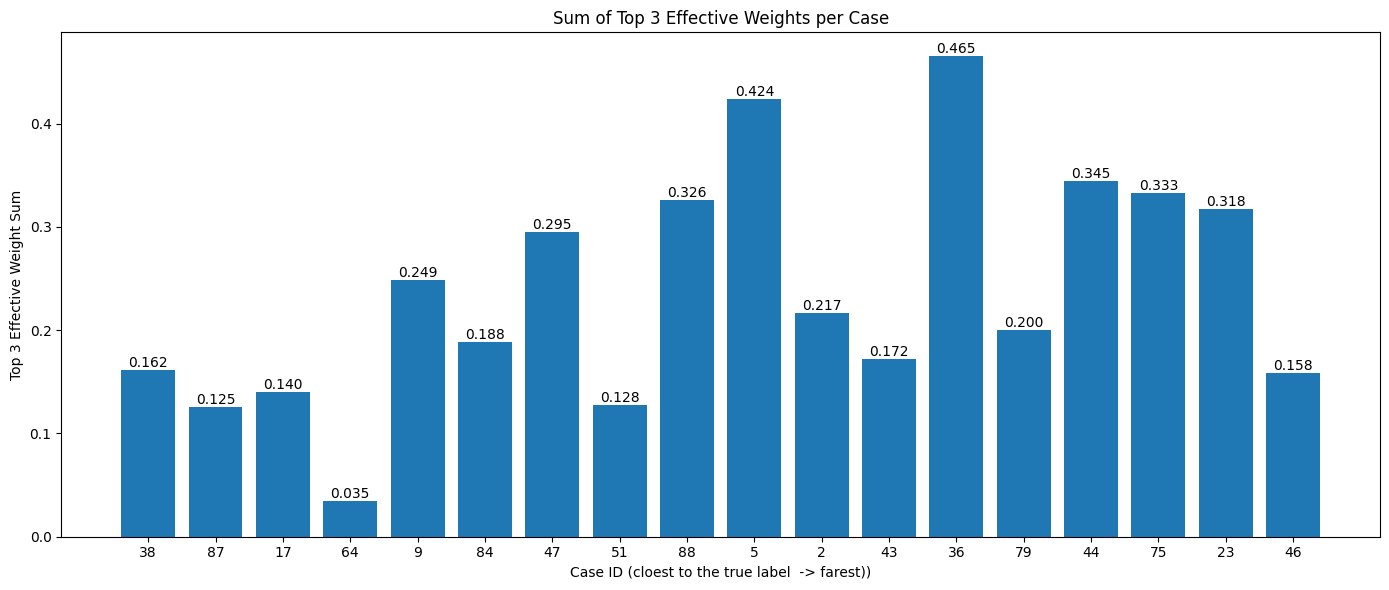

In [36]:
# Compute top-3 sum of effective weights per case
top3_sums = (
    merged.groupby("case_id")["effective_weight"]
          .apply(lambda x: x.nlargest(3).sum())
)

# Get abs_gap per case (unique per case_id)
gap_map = merged.groupby("case_id")["abs_gap"].first()

# Create a dataframe to sort properly
plot_df = pd.DataFrame({
    "top3_sum": top3_sums,
    "abs_gap": gap_map
})

# Sort by abs_gap ascending
plot_df = plot_df.sort_values("abs_gap", ascending=True)

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(plot_df.index.astype(str), plot_df["top3_sum"].values)

plt.title("Sum of Top 3 Effective Weights per Case")
plt.xlabel("Case ID (cloest to the true label  -> farest))")
plt.ylabel("Top 3 Effective Weight Sum")

# Add numeric labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xticks()
plt.tight_layout()
plt.show()


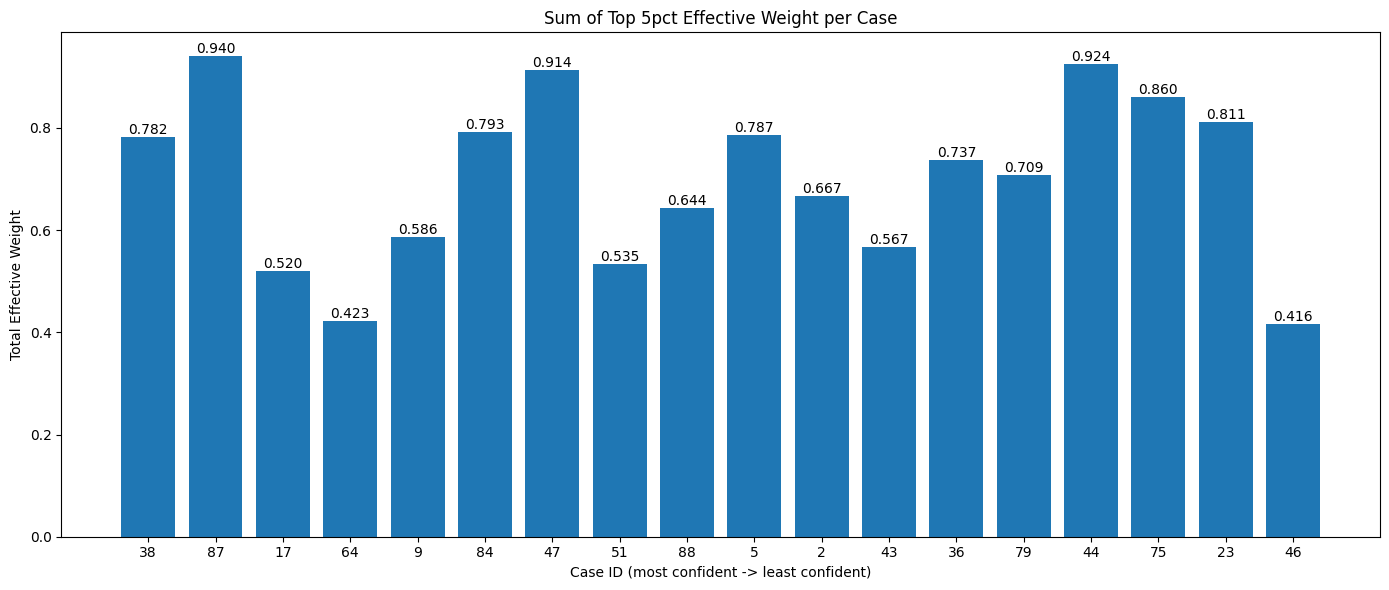

In [31]:
# Sum of effective weights per case
case_sums = merged.groupby("case_id")["effective_weight"].sum()

# Grab abs_gap per case (unique for each case_id)
gap_map = merged.groupby("case_id")["abs_gap"].first()

# Combine into a single dataframe for proper sorting
plot_df = pd.DataFrame({
    "total_sum": case_sums,
    "abs_gap": gap_map
})

# Sort by abs_gap ascending
plot_df = plot_df.sort_values("abs_gap", ascending=True)

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(plot_df.index.astype(str), plot_df["total_sum"].values)

plt.title("Sum of Top 5pct Effective Weight per Case")
plt.xlabel("Case ID (most confident -> least confident)")
plt.ylabel("Total Effective Weight")

# Add numeric labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xticks()
plt.tight_layout()
plt.show()
